In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import warnings
from statsmodels.stats.proportion import proportions_ztest

In [43]:
marketplace_df = pd.read_csv('marketplace.csv')
marketplace_df.sample(5)

,Unnamed: 0,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
1519,1519,2024-10-15 21:15:51,2024-10-15 21:43:46,7098771,М,mobile,детские товары,True,12,3,3634
2160,2160,2024-10-22 03:34:00,2024-10-22 03:56:13,7940336,Ж,desktop,товары для животных,False,0,2,412
4825,4825,2024-11-12 19:09:55,2024-11-12 19:26:42,6476967,М,desktop,канцелярия,True,6,6,3971
8038,8038,2024-12-03 23:25:06,2024-12-03 23:47:45,8155966,М,mobile,электроника,False,0,1,21386
7327,7327,2024-11-29 05:00:51,2024-11-29 05:31:03,3142793,Ж,desktop,одежда и обувь,False,0,1,1909


In [44]:
marketplace_df = marketplace_df.drop('Unnamed: 0',axis = 1)

In [45]:
marketplace_df.shape

(13620, 10)

In [46]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_session       13620 non-null  object
 1   end_session         13620 non-null  object
 2   user_id             13620 non-null  int64 
 3   sex                 13620 non-null  object
 4   platform            13620 non-null  object
 5   category            13620 non-null  object
 6   consultation        13620 non-null  bool  
 7   cons_duration       13620 non-null  int64 
 8   number_of_products  13620 non-null  int64 
 9   basket_amount       13620 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 971.1+ KB


#### В датафрейме нет пустых значений

In [47]:
marketplace_df.describe()

,user_id,cons_duration,number_of_products,basket_amount
count,1.362000e+04,13620.000000,13620.000000,13620.000000
mean,5.014737e+06,3.769971,3.480617,8070.579148
std,2.321852e+06,5.206834,1.717339,10664.396801
min,1.000078e+06,0.000000,1.000000,72.000000
25%,3.030951e+06,0.000000,2.000000,1203.750000
50%,4.995020e+06,0.000000,3.000000,3834.500000
75%,7.056691e+06,8.000000,5.000000,10171.500000
max,8.999642e+06,19.000000,6.000000,53385.000000


In [48]:
# переводим небходимые столбцы в дату
marketplace_df['start_session'] = pd.to_datetime(marketplace_df['start_session'])
marketplace_df['end_session'] = pd.to_datetime(marketplace_df['end_session'])

In [49]:
# поиск возможных пустых значенйи в столбце
def check_masked_missing(df, column):
        
        # 1. Стандартные NaN/None
        nan_count = df[column].isna().sum()
        print(f"NaN/None: {nan_count}")
        
        # 2. Пустые строки ''
        empty_str = (df[column] == '').sum()
        print(f"Пустые строки (''): {empty_str}")
        
        # 3. Пробелы ' ', '\\t', '\\n'
        whitespace = df[column].astype(str).str.strip().eq('').sum()
        print(f"Только пробелы: {whitespace}")
        
        # 4. Специальные символы: ?, -, N/A, NULL, пусто
        suspicious = df[column].astype(str).str.lower()
        masks = ['?', '-', 'n/a', 'na', 'null', 'none', 'nan', '','!']
        for mask in masks:
            count = (suspicious == mask).sum()
            if count > 0:
                print(f"'{mask}': {count}")
        
        # 5. Строки из пробелов разной длины
        space_only = suspicious.str.match(r'^\s*$').sum()
        print(f"Только пробелы (regex): {space_only}")
        

In [50]:
check_masked_missing(marketplace_df, 'end_session')

NaN/None: 0
Пустые строки (''): 0
Только пробелы: 0
Только пробелы (regex): 0


## Верно ли, что женщины тратят больше денег на покупки на ВезуМаркет?

In [51]:
marketplace_df['month'] = marketplace_df['end_session'].dt.strftime('%Y-%m')

In [52]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [53]:
# Разбивка расходов по месяцам
cost_df = marketplace_df.groupby(['month','sex'],as_index=False) \
    .agg({'basket_amount':'sum'}).rename(columns={'basket_amount':'total_spending'})
cost_df

,month,sex,total_spending
0,2024-10,Ж,12280043
1,2024-10,М,12809949
2,2024-11,Ж,17720267
3,2024-11,М,16891579
4,2024-12,Ж,25781533
5,2024-12,М,24437917


In [54]:
women_sum = cost_df[cost_df['sex'] == 'Ж']['total_spending'].sum()
print(f'Женщины потратили на ВезуМаркет: {women_sum} руб.')

Женщины потратили на ВезуМаркет: 55781843 руб.


In [55]:
men_sum = cost_df[cost_df['sex'] == 'М']['total_spending'].sum()
print(f'Мужчины в сумме потратили на ВезуМаркет: {men_sum} руб.')

Мужчины в сумме потратили на ВезуМаркет: 54139445 руб.


### H0: Средний чек мужчин и женщин на платформе ВезуМаркет одинаковый
### H1: Средний чек мужчин и женщин на платформе ВезуМаркет отличается

In [56]:
df_women = marketplace_df.query('sex == "Ж"')

In [57]:
df_women.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
3774,2024-11-05 18:38:36,2024-11-05 18:59:11,6594713,Ж,mobile,одежда и обувь,True,6,3,132,2024-11
93,2024-10-01 20:21:29,2024-10-01 20:59:03,6241801,Ж,mobile,все для дома,False,0,6,34672,2024-10
8914,2024-12-08 11:08:16,2024-12-08 11:32:03,2769874,Ж,mobile,все для дома,False,0,3,4703,2024-12
5166,2024-11-15 00:04:15,2024-11-15 00:32:36,7672565,Ж,desktop,одежда и обувь,False,0,6,13331,2024-11
11686,2024-12-22 09:38:54,2024-12-22 10:18:09,1054140,Ж,desktop,все для дома,True,17,2,4367,2024-12


In [58]:
df_women.shape

(6887, 11)

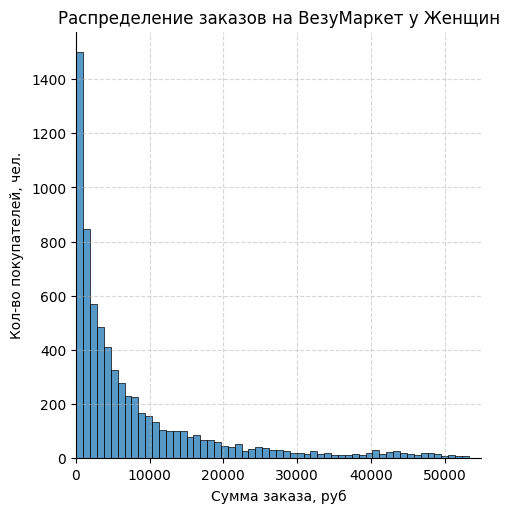

In [59]:
# визуализация
sns.displot(df_women["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Женщин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [60]:
# основные показатели у женщин
print(f'Средний чек заказа на ВезуМаркет у женщин: {df_women["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у женщин: {df_women["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у женщиин: {np.std(df_women["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у женщин: 8100 руб.
Дисперсия суммы заказов на ВезуМаркет у женщин: 113142487 руб.
СКО суммы заказов на ВезуМаркет у женщиин: 10636 руб.


In [61]:
df_men = marketplace_df.query('sex == "М"')

In [62]:
df_men.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
12958,2024-12-28 14:30:30,2024-12-28 15:02:07,1377077,М,mobile,одежда и обувь,False,0,6,1881,2024-12
3522,2024-11-04 00:52:46,2024-11-04 01:21:39,1387494,М,mobile,все для дома,False,0,2,6953,2024-11
4144,2024-11-08 05:47:54,2024-11-08 06:23:22,8660584,М,mobile,товары для животных,False,0,1,384,2024-11
1810,2024-10-18 20:09:21,2024-10-18 20:35:25,5052857,М,mobile,детские товары,True,10,5,20184,2024-10
6046,2024-11-20 21:16:33,2024-11-20 21:34:36,6252981,М,desktop,детские товары,True,6,1,355,2024-11


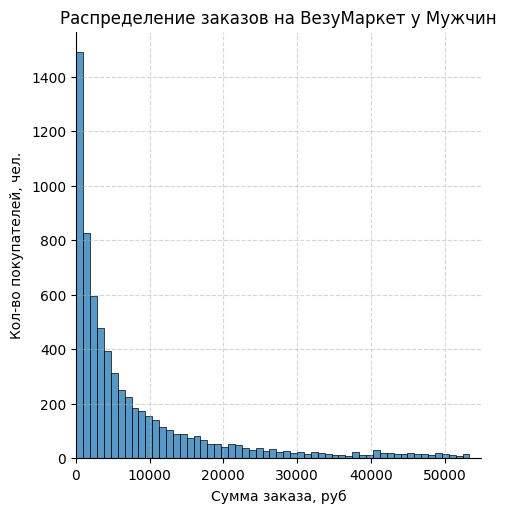

In [63]:
# визуализация
sns.displot(df_men["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Мужчин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [64]:
# основные показатели у мужчин
print(f'Средний чек заказа на ВезуМаркет у мужчин: {df_men["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у мужчин: {df_men["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у мужчин: {np.std(df_men["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у мужчин: 8041 руб.
Дисперсия суммы заказов на ВезуМаркет у мужчин: 114344809 руб.
СКО суммы заказов на ВезуМаркет у мужчин: 10692 руб.


In [65]:
# проверка на нормальность распредления
warnings.filterwarnings('ignore')

stat1, p1 = st.shapiro(df_women["basket_amount"])
stat2, p2 = st.shapiro(df_men["basket_amount"])
if p1 > 0.05 and p2 > 0.05:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

warnings.filterwarnings('default')


Данные распределены не нормально


In [66]:
# Тест Андерсона-Дарлинга
result_w = st.anderson(df_women["basket_amount"])
result_m = st.anderson(df_men["basket_amount"])

if result_w.statistic < result_w.critical_values[2] and result_m.statistic < result_m.critical_values[2]:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

Данные распределены не нормально


In [67]:
# U-тест Манна-Уитни
stat, p_value = st.mannwhitneyu(df_women["basket_amount"], df_men["basket_amount"])

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Нет оснований отвергнуть нулевую гипотезу


#### Вывод - за исследумые период женщины потратили больше на ВезуМаркет, но при этом нет оснований отвергать, что средний чек у обоих групп различаются

## Верно ли, что женщины совершают больше покупок на ВезуМаркет?

In [68]:
freq_df = marketplace_df.groupby('sex',as_index=False) \
    .agg({'user_id':'count'}).rename(columns={'user_id':'number_of_clients'})
freq_df

,sex,number_of_clients
0,Ж,6887
1,М,6733


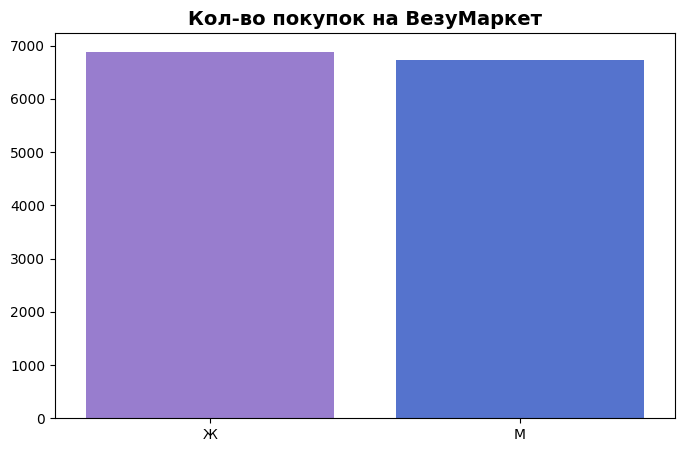

In [69]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='sex', y='number_of_clients',data=freq_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во покупок на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

#### Вывод - за исследуемый период женщины совершали чаще покупки на ВезуМаркет

## Верно ли, что объем продаж через веб-сайт и мобильное приложение не различается?

In [70]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [71]:
# кол-во уникальных записей в разрезе платформ
marketplace_df.platform.value_counts()

platform
mobile     7991
desktop    5629
Name: count, dtype: int64

In [72]:
# фильтруем датафрей по платформам
mobile_df = marketplace_df.query('platform == "mobile"')
dekstop_df = marketplace_df.query('platform == "desktop"')

In [73]:
# объемы продаж
mobile_volume = np.sum(mobile_df.number_of_products)
dekstop_volume = np.sum(dekstop_df.number_of_products)
print(f'Объем продаж через мобильное приложение: {mobile_volume} товаров')
print(f'Объем продаж через сайт: {dekstop_volume} товаров')

Объем продаж через мобильное приложение: 27799 товаров
Объем продаж через сайт: 19607 товаров


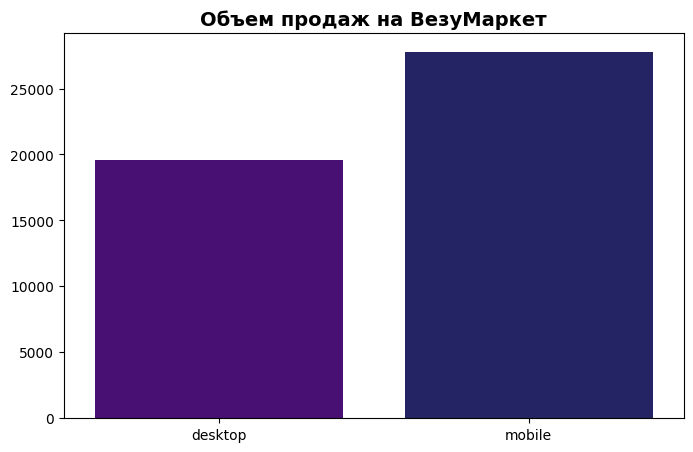

In [92]:
# визуализация
df_volume = marketplace_df.groupby('platform',as_index=False).agg({'number_of_products':'sum'})

warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='number_of_products',data=df_volume, palette=['indigo','midnightblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Объем продаж на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: объем продаж через веб-сайт и мобильное приложение не различается
### H1: объем продаж через веб-сайт и мобильное приложение различается

In [75]:
dekstop_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
6,2024-10-01 01:26:42,2024-10-01 01:56:58,3365488,М,desktop,все для дома,False,0,4,23301,2024-10
7,2024-10-01 01:37:37,2024-10-01 02:11:07,6286723,Ж,desktop,красота и здоровье,False,0,6,2575,2024-10
9,2024-10-01 01:39:36,2024-10-01 02:14:10,8280464,Ж,desktop,одежда и обувь,True,13,4,26667,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13606,2024-12-31 21:49:44,2024-12-31 22:26:16,7147054,Ж,desktop,красота и здоровье,False,0,1,4347,2024-12
13613,2024-12-31 22:37:45,2024-12-31 22:55:59,4221401,М,desktop,электроника,True,7,4,167,2024-12
13617,2024-12-31 23:17:55,2024-12-31 23:28:25,3864302,Ж,desktop,красота и здоровье,False,0,3,4760,2024-12
13618,2024-12-31 23:23:46,2024-12-31 23:53:51,2361461,М,desktop,одежда и обувь,True,9,2,324,2024-12


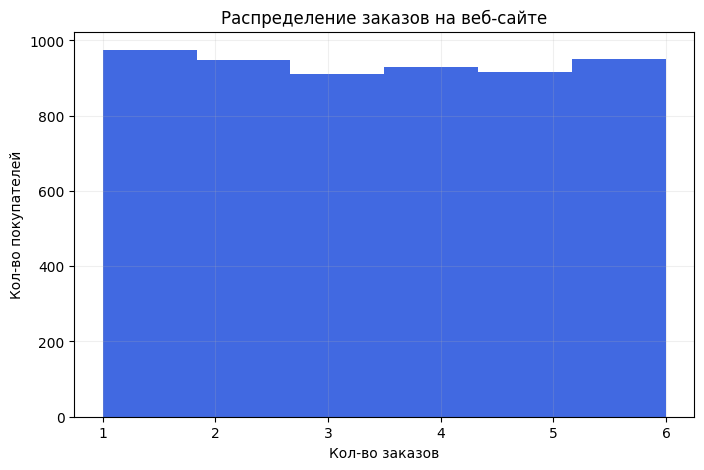

In [76]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(dekstop_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов на веб-сайте')
plt.grid(True, alpha=0.2)
plt.show()

In [77]:
# основные показатели
print(f"Среднее количество товаров: {dekstop_df['number_of_products'].mean():.2f}")
print(f"Медиана: {dekstop_df['number_of_products'].median():.2f}")
print(f"Мода: {dekstop_df['number_of_products'].mode()[0]}")
print(f"Std: {dekstop_df['number_of_products'].std():.2f}")
print(f"Минимум: {dekstop_df['number_of_products'].min()}")
print(f"Максимум: {dekstop_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.72
Минимум: 1
Максимум: 6


In [78]:
mobile_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10
5,2024-10-01 01:23:00,2024-10-01 01:52:18,3046228,М,mobile,одежда и обувь,True,10,5,11364,2024-10
8,2024-10-01 01:38:22,2024-10-01 01:56:48,8145525,Ж,mobile,одежда и обувь,True,8,2,10430,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13611,2024-12-31 22:19:13,2024-12-31 22:41:45,7046417,Ж,mobile,одежда и обувь,True,11,3,1939,2024-12
13612,2024-12-31 22:24:40,2024-12-31 22:34:54,6543447,М,mobile,товары для животных,False,0,4,904,2024-12
13614,2024-12-31 22:45:30,2024-12-31 23:06:44,4283046,Ж,mobile,детские товары,False,0,3,6299,2024-12
13615,2024-12-31 22:58:24,2024-12-31 23:11:40,7766167,М,mobile,одежда и обувь,False,0,3,1632,2024-12


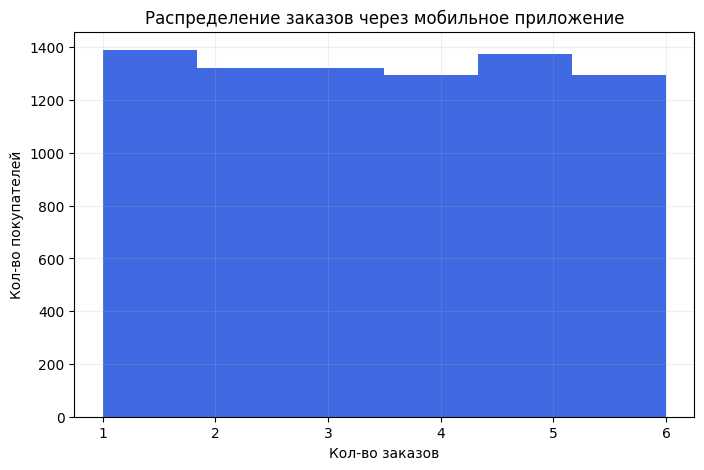

In [79]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(mobile_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов через мобильное приложение')
plt.grid(True, alpha=0.2)
plt.show()

In [80]:
# основные показатели
print(f"Среднее количество товаров: {mobile_df['number_of_products'].mean():.2f}")
print(f"Медиана: {mobile_df['number_of_products'].median():.2f}")
print(f"Мода: {mobile_df['number_of_products'].mode()[0]}")
print(f"Std: {mobile_df['number_of_products'].std():.2f}")
print(f"Минимум: {mobile_df['number_of_products'].min()}")
print(f"Максимум: {mobile_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.71
Минимум: 1
Максимум: 6


#### Основываясь на статистических показателях, мы не стали проверять гипотезы, так как объем продаж через мобильное приложение выше только лишь за счет количества заказов, но само распределение одинаковое.

## Верно ли, что через мобильное приложение и веб-сайт покупки совершает одинаковое количество покупателей?

In [87]:
# кол-во уникальных пользователей на кажой платформе
users_df = marketplace_df.groupby('platform', as_index=False) \
    .agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})
users_df

,platform,users
0,desktop,4580
1,mobile,5992


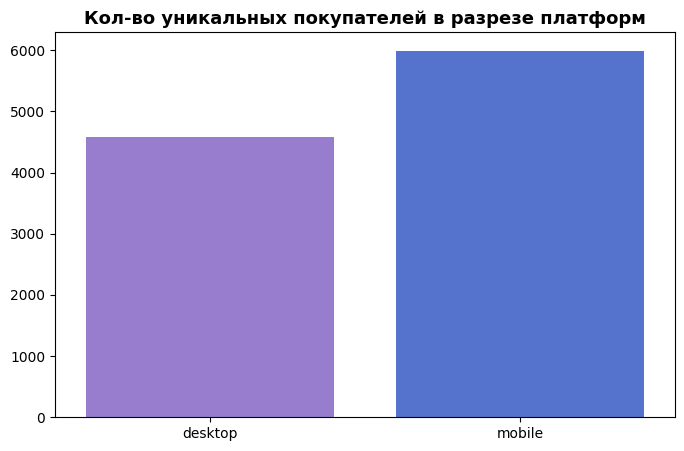

In [93]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='users',data=users_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во уникальных покупателей в разрезе платформ',fontdict={'fontsize':13,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: через мобильное приложение и веб-сайт покупки совершает одинаковое кол-во покупателей
### H1: через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей

In [99]:
# общее и уникальное кол-во пользователей
dekstop_users = dekstop_df.shape[0]
mobile_users = mobile_df.shape[0]
dekstop_uniq = users_df.users[0]
monile_uniq = users_df.users[1]

In [118]:
# Z-тест для пропорций 
count=[dekstop_uniq,monile_uniq]
nobs = [dekstop_users,mobile_users]

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print('Количество покупателей различается, есть статистически значимые различия')
else:
    print('Количество покупателей одинаково, нет статистически значимых различий')

Z-статистика: 8.7971
p-value: 1.4039151313786243e-18
Количество покупателей различается, есть статистически значимые различия


#### Вывод - через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей 

## Верно ли, что через мобильное приложение покупатели чаще обращаются за консультацией?